In [1]:
%%time
from sklearn.datasets import load_files
import numpy as np
import re

# 整理 aclImdb 目录下的数据
print("整理数据中...")

# 清洗文本
def wash_text(text):
    text = text.lower().replace(u'\x85', '').replace(u'\n', '').replace(u'<br/>', '').replace('<br />', '')
    # 把标点符号算作一个词
    text = re.sub(r"([\.\",\(\)!\?;:])", " \\1 ", text)
    return text

# 使用 sklearn 的 load_files 导入 category/data.txt 格式的目录, 并且去掉 unsup 分类
reviews_train = load_files("data/aclImdb/train/")
unsup_index = reviews_train.target_names.index('unsup')
text_train = []
y_train = []
text_unsup = []
for t, y in zip(reviews_train.data, reviews_train.target):
    if y != unsup_index:
        text_train.append(wash_text(t.decode('utf-8')))
        y_train.append(y)
    else:
        text_unsup.append(wash_text(t.decode('utf-8')))

print("训练用评论: {}".format(len(text_train)))
print("训练用评论(按pos/neg分类): {}".format(np.bincount(y_train)))

print("非监督(聚类)用评论: {}".format(len(text_unsup)))

reviews_test = load_files("data/aclImdb/test/")
text_test = [wash_text(t.decode('utf-8')) for t in reviews_test.data]
y_test = reviews_test.target
        
print("测试用评论: {}".format(len(text_test)))
print("测试用评论(按pos/neg分类): {}".format(np.bincount(y_test)))

整理数据中...
训练用评论: 25000
训练用评论(按pos/neg分类): [12500 12500]
非监督(聚类)用评论: 50000
测试用评论: 25000
测试用评论(按pos/neg分类): [12500 12500]
CPU times: user 4.04 s, sys: 397 ms, total: 4.44 s
Wall time: 4.44 s


In [1]:
%%time
# 加载词向量映射表文件
from gensim.models import KeyedVectors

current_model = KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin', binary=True)

CPU times: user 39.7 s, sys: 2.34 s, total: 42 s
Wall time: 42.2 s


In [3]:
%%time
# 尝试用一下这个词向量映射表
current_model.most_similar(positive=['computer', 'portable', 'charger'], topn=5)

CPU times: user 847 ms, sys: 1.97 ms, total: 849 ms
Wall time: 148 ms


[('laptop', 0.7337002754211426),
 ('Walkman_Obit_Remembering', 0.6833795309066772),
 ('rechargable_batteries', 0.6630346179008484),
 ('MP3_player', 0.6521008610725403),
 ('USB_charger', 0.6487280130386353)]

In [3]:
current_model.vector_size

300

[-0.15 -0.17 -0.03  0.22  0.13 -0.09  0.23 -0.11 -0.3   0.03 -0.21 -0.39
  0.09  0.09  0.01  0.31 -0.03 -0.36 -0.09 -0.33  0.07  0.22  0.23 -0.01
  0.29 -0.02 -0.28 -0.3  -0.04  0.2  -0.01 -0.23  0.16 -0.08 -0.27 -0.05
  0.15  0.01  0.03  0.2  -0.   -0.33  0.23  0.03  0.29 -0.25 -0.26  0.24
  0.05  0.12 -0.22  0.26  0.07 -0.12 -0.22 -0.15  0.21 -0.03 -0.19 -0.12
  0.05  0.12  0.11  0.17 -0.    0.22 -0.25 -0.27  0.06  0.29 -0.02 -0.1
  0.15  0.03  0.03 -0.12 -0.11  0.04  0.16 -0.08  0.03 -0.02  0.25 -0.21
 -0.09 -0.53 -0.14  0.39  0.09  0.23  0.04 -0.36 -0.2   0.06 -0.11  0.01
 -0.06 -0.09  0.23 -0.01 -0.06 -0.06  0.02  0.12 -0.24  0.02  0.2  -0.08
 -0.25 -0.26 -0.28 -0.24 -0.08  0.31  0.04  0.02  0.21 -0.25  0.05 -0.03
  0.03  0.11  0.06  0.08  0.03 -0.   -0.17 -0.1   0.18  0.07 -0.03  0.38
  0.13  0.1  -0.2   0.34 -0.25 -0.17  0.12  0.12 -0.01 -0.14  0.15 -0.29
  0.    0.24  0.01 -0.11 -0.15 -0.07 -0.03  0.08 -0.23  0.39 -0.06 -0.25
 -0.19 -0.1  -0.46 -0.07 -0.02 -0.03  0.27  0.01  0.

In [12]:
%%time
from tqdm import tqdm_notebook
# 然后把所有的 train 文本, 向量化, 编程供 Logistic Regression 学习器学习的张量
order_map = np.arange(len(text_train))
np.random.shuffle(order_map)

sample_num = len(text_train)
features_train_shuffled = np.ndarray((sample_num, current_model.vector_size))

features_num = current_model.vector_size
text_train_shuffled = np.array(text_train)[order_map]

for i, text in tqdm_notebook(enumerate(text_train_shuffled), total=sample_num):
    this_row = np.zeros((features_num, ))
    word_num = 0
    for word in text.split():
        try:
            this_row += current_model[word]
            word_num += 1
        except KeyError:
            pass
    this_row /= word_num
    features_train_shuffled[i,:] = this_row
    
y_train_shuffled = np.asarray(y_train)[order_map]


CPU times: user 16.7 s, sys: 1.72 s, total: 18.4 s
Wall time: 17.3 s


In [13]:
text_train_shuffled[2], y_train_shuffled[2]

(' " dressed to kill "  is surely one of the best horror/thriller movies ever made . it\'s taut , stylish and extremely suspenseful mixture of sex and violence . the acting is pretty good , the orchestral score by pino donaggio is unforgettable and there\'s plenty of surprises to keep thriller fans intrigued .  " dressed to kill "  is a murder mystery that involves a sexually frustrated housewife ( angie dickinson )  , her teenage son ( keith gordon )  , her psychoanalyst ( michael caine )  , and a high price call girl ( nancy allen )  . the murderer in the film is a transsexual named bobbi who is also one of caine\'s patients . the film is full of breathtaking moments : the infamous elevator murder scene is extremely stylish and pretty gory as well . highly recommended . ',
 1)

In [14]:
import time
# 开始 Logistic 部分 (纯 Python)
# 输入: features_train
minibatch_size = 50
def get_minibatch(x_train, y_train, minibatch_size):
    for i in range(0, sample_num, minibatch_size):
        yield x_train[i:i+minibatch_size], y_train[i:i+minibatch_size]

def sigmoid(x):
    return 1. / (1 + np.exp(-x))
        
learning_rate = 0.02

theta = np.random.randn(features_num)

for epoch in range(200):
    total_abs_loss = 0
    total_loss = 0
    for i, (x_batch, y_batch) in enumerate(get_minibatch(features_train_shuffled, y_train_shuffled, minibatch_size)):
        outputs = sigmoid(np.dot(x_batch, theta))
        individual_cel = - y_batch * np.log(outputs) - (1 - y_batch) * np.log(1 - outputs)
        cross_entropy_loss = individual_cel.sum()
        
        total_abs_loss += np.abs(outputs - y_batch).sum()
        total_loss += cross_entropy_loss
        
        partial_common = (outputs - y_batch)
        delta_theta = (partial_common[:, np.newaxis] * x_batch).sum(axis=0)
        theta -= learning_rate * delta_theta
        
    avg_loss = total_loss
    print("Epoch %d : Avg Loss %f" % (epoch, avg_loss))

Epoch 0 : Avg Loss 15806.610850
Epoch 1 : Avg Loss 14006.161247
Epoch 2 : Avg Loss 13014.292976
Epoch 3 : Avg Loss 12361.333688
Epoch 4 : Avg Loss 11892.476851
Epoch 5 : Avg Loss 11536.875977
Epoch 6 : Avg Loss 11256.272404
Epoch 7 : Avg Loss 11027.988659
Epoch 8 : Avg Loss 10837.708158
Epoch 9 : Avg Loss 10675.948732
Epoch 10 : Avg Loss 10536.182676
Epoch 11 : Avg Loss 10413.769507
Epoch 12 : Avg Loss 10305.319302
Epoch 13 : Avg Loss 10208.297024
Epoch 14 : Avg Loss 10120.767890
Epoch 15 : Avg Loss 10041.228521
Epoch 16 : Avg Loss 9968.492005
Epoch 17 : Avg Loss 9901.607843
Epoch 18 : Avg Loss 9839.805027
Epoch 19 : Avg Loss 9782.450840
Epoch 20 : Avg Loss 9729.020530
Epoch 21 : Avg Loss 9679.074660
Epoch 22 : Avg Loss 9632.241960
Epoch 23 : Avg Loss 9588.206182
Epoch 24 : Avg Loss 9546.695917
Epoch 25 : Avg Loss 9507.476611
Epoch 26 : Avg Loss 9470.344253
Epoch 27 : Avg Loss 9435.120336
Epoch 28 : Avg Loss 9401.647807
Epoch 29 : Avg Loss 9369.787771
Epoch 30 : Avg Loss 9339.416807
Ep

In [15]:
(abs(sigmoid(np.dot(features_train_shuffled, theta)) - y_train_shuffled)).sum() / sample_num

0.2132376501442336

In [16]:
%%time
# sklearn 的 LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(solver='sag'), param_grid, cv=5)
grid.fit(features_train_shuffled, y_train_shuffled)

print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)

lr = grid.best_estimator_

Best cross-validation score: 0.86
Best parameters:  {'C': 10}
Best estimator:  LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='sag',
          tol=0.0001, verbose=0, warm_start=False)
CPU times: user 43.9 s, sys: 225 ms, total: 44.1 s
Wall time: 18.9 s


In [17]:
def apply_logistic_purelr(x):
    return np.around(sigmoid(np.dot(x, theta))).astype(np.int)

def apply_logistic_sklearnlr(x):
    return lr.predict(x)

In [18]:
%%time
features_test = np.ndarray((len(text_test), features_num))
test_num = len(text_test)

for i, text in tqdm_notebook(enumerate(text_test), total=len(text_test)):
    this_row = np.zeros((features_num, ))
    word_num = 0
    for word in text.split():
        try:
            this_row += current_model[word]
            word_num += 1
        except KeyError:
            pass
    this_row /= word_num
    features_test[i,:] = this_row
    
y_test = np.asarray(y_test)


CPU times: user 14.4 s, sys: 664 ms, total: 15.1 s
Wall time: 14.5 s


In [19]:
print(apply_logistic_purelr(features_test[0:100]) == y_test[0:100])
print(apply_logistic_sklearnlr(features_test[0:100]) == y_test[0:100])

[ True  True  True  True  True  True  True  True  True  True  True False
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False  True
  True  True  True  True  True  True  True False  True  True  True  True
  True False  True  True  True  True  True  True False False  True  True
  True  True  True  True  True False  True  True  True  True False False
  True  True  True  True  True False  True False  True  True  True  True
  True  True  True  True  True  True  True  True  True False  True  True
  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False  True
  True  True  True  True  True  True  True False  True  True  True  True
  True False  True  True  True  True  True  True False False  True  True
  True  True  True  True 

In [20]:
def test_score_purelr():
    return (apply_logistic_purelr(features_test) == y_test).sum() / features_test.shape[0]

def test_score_sklearnlr():
    return lr.score(features_test, y_test)

print(test_score_purelr())
print(test_score_sklearnlr())

0.85876
0.86


In [22]:
def train_score_purelr():
    return (apply_logistic_purelr(features_train_shuffled) == y_train_shuffled).sum() / features_train_shuffled.shape[0]

def train_score_sklearnlr():
    return lr.score(features_train_shuffled, y_train_shuffled)

print(train_score_purelr())
print(train_score_sklearnlr())

0.8616
0.86284


In [27]:
import matplotlib.pyplot as plt
from importlib import reload
reload(plt)
%matplotlib inline

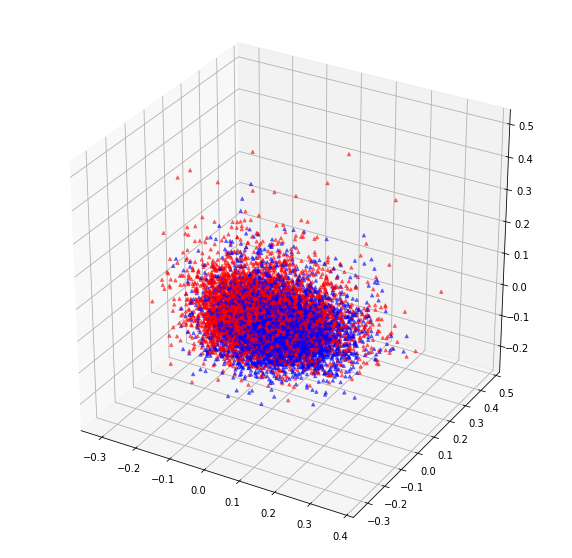

In [28]:
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer
from mpl_toolkits.mplot3d import Axes3D, axes3d

svd = TruncatedSVD(n_components=3)
pca = PCA(n_components=3)

sample_features = features_test[np.random.choice(features_test.shape[0], 10000, replace=False), :]

current_reduce_algorithm = pca

current_reduce_algorithm.fit(features_test)
reduced_x = current_reduce_algorithm.transform(sample_features)
pos_x,pos_y,pos_z = [],[],[]
neg_x,neg_y,neg_z = [],[],[]

y_plot_pre = apply_logistic_purelr(sample_features)


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(reduced_x[:,0],reduced_x[:,1],reduced_x[:,2],c=list(map(lambda x:['b','r'][x], y_plot_pre)),marker='^',s=10,alpha=0.5)

plt.show()

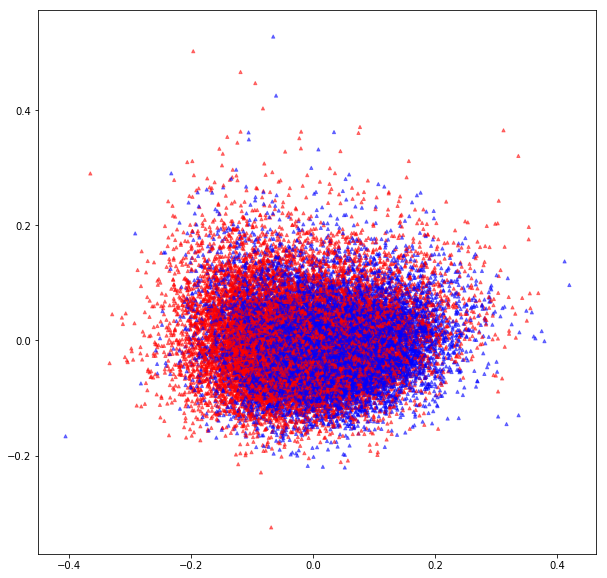

In [29]:
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer
from mpl_toolkits.mplot3d import Axes3D, axes3d

svd = TruncatedSVD(n_components=2)
pca = PCA(n_components=2)

sample_features = features_test[np.random.choice(features_test.shape[0], 25000, replace=False), :]

current_reduce_algorithm = pca

current_reduce_algorithm.fit(features_test)
reduced_x = current_reduce_algorithm.transform(sample_features)
pos_x,pos_y,pos_z = [],[],[]
neg_x,neg_y,neg_z = [],[],[]

y_plot_pre = apply_logistic_purelr(sample_features)

for i in range(len(y_plot_pre)):
    if y_plot_pre[i] == 0:
        neg_x.append(reduced_x[i][0])
        neg_y.append(reduced_x[i][1])
    else:
        pos_x.append(reduced_x[i][0])
        pos_y.append(reduced_x[i][1])

fig = plt.figure(figsize=(10,10))

plt.scatter(reduced_x[:,0],reduced_x[:,1],c=list(map(lambda x:['b','r'][x], y_plot_pre)),marker='^',s=10,alpha=0.5)

plt.show()

<Figure size 432x288 with 0 Axes>

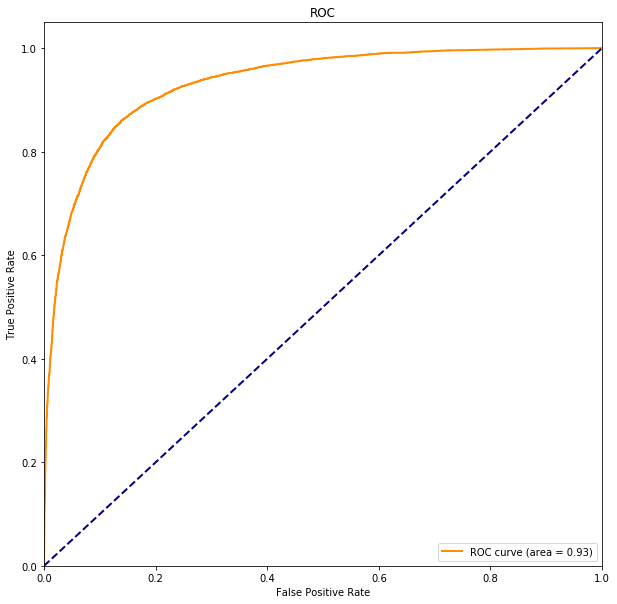

In [30]:
from sklearn.metrics import roc_curve, auc

y_plot_pre = grid.best_estimator_.decision_function(features_test)

fpr, tpr, threshold = roc_curve(y_test, y_plot_pre) ###计算真正率和假正率
roc_auc = auc(fpr, tpr) ###计算auc的值
 
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

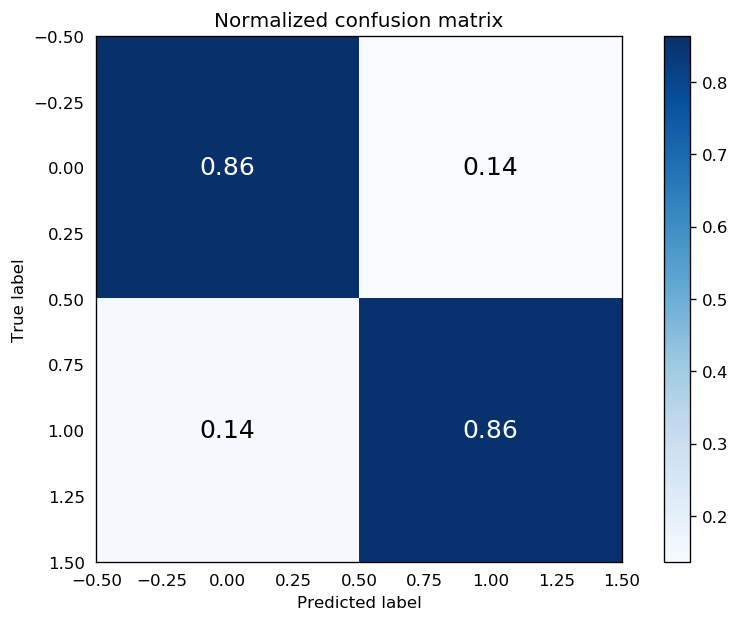

In [31]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, title='Confusion Matrix', cmap = plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
y_plot_pre = lr.predict(features_test)
cm = confusion_matrix(y_test, y_plot_pre)
np.set_printoptions(precision=2)
cm_normalized = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(9,6), dpi=120)
ind_array = np.arange(2)
x, y = np.meshgrid(ind_array, ind_array)
 
for x_val, y_val in zip(x.flatten(), y.flatten()):
    thresh = cm_normalized.max()/2
    c = cm_normalized[y_val][x_val]
    if (c > 0.01):
        plt.text(x_val, y_val, "%0.2f" %(c,), color='white' if cm_normalized[x_val, y_val] > thresh else "black", fontsize=15, va='center', ha='center')
plt.gca().xaxis.set_ticks_position('none')
plt.gca().yaxis.set_ticks_position('none')
plt.grid(True, which='minor', linestyle='-')
plt.gcf().subplots_adjust(bottom=0.15)
 
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')
#show confusion matrix
plt.show()